## Importing Libraries

### Data Visualisation and Preprocessing


In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
import seaborn as sns
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings("ignore")

### Image Processing

In [ ]:
import cv2

### Tensorflow and Keras

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,losses
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, AveragePooling2D ,Dense , Flatten , Dropout, GlobalAveragePooling2D
from tensorflow.keras.losses import CategoricalCrossentropy , BinaryCrossentropy
from tensorflow.keras.metrics import Recall ,Precision,Accuracy
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import balanced_accuracy_score , classification_report , mean_squared_error
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers as layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers, optimizers
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, RMSprop
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.models import Model

## Importing the Dataset

In [ ]:
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/MyDrive/Driver Drowsiness Dataset (DDD)'
#path_drowsy = '/content/drive/MyDrive/Driver Drowsiness Dataset (DDD)/Drowsy'
#path_non_drowsy = '/content/drive/MyDrive/Driver Drowsiness Dataset (DDD)/Non Drowsy'
dirs=os.listdir(path)
#dirs1=os.listdir(path_drowsy)
#dirs2=os.listdir(path_non_drowsy)
os.chdir(path)

Mounted at /content/drive


In [ ]:
import skimage
from skimage.transform import resize
from tqdm import tqdm
def get_data(folder):
    X = []
    y = []
    for folderName in dirs:
        if not folderName.startswith('.'):
            if folderName in ['Drowsy']:
                label = 0
            elif folderName in ['Non Drowsy']:
                label = 1
            for image_filename in tqdm(os.listdir(folder +'/'+ folderName)):
                img_file = cv2.imread(folder +'/'+ folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (50, 50, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y
X_train, y_train = get_data(path)

100%|██████████| 19455/19455 [14:54<00:00, 21.74it/s]


In [ ]:
import sys
import gc
gc.collect()

8

## Data Preprocessing

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2,random_state=42)

In [ ]:
print("The shape of X_train is : ", X_train.shape)
print("The shape of y_train is : ", y_train.shape)

The shape of X_train is :  (33442, 50, 50, 3)
The shape of y_train is :  (33442,)


In [ ]:
print("The shape of one image is : ", X_train[0].shape)

The shape of one image is :  (50, 50, 3)


In [ ]:
y_trainHot = to_categorical(y_train, num_classes = 2)
y_testHot = to_categorical(y_test, num_classes = 2)

In [ ]:
print(X_test.shape)
print(y_test.shape)
print(y_trainHot.shape)
print(y_testHot.shape)

(8361, 50, 50, 3)
(8361,)
(33442, 2)
(8361, 2)


In [ ]:
from sklearn.utils import shuffle
X_train, y_trainHot = shuffle(X_train, y_trainHot, random_state=13)
X_test, y_testHot = shuffle(X_test, y_testHot, random_state=13)
X_train = X_train[:30000]
X_test = X_test[:30000]
y_trainHot = y_trainHot[:30000]
y_testHot = y_testHot[:30000]

In [ ]:
map_characters = {0: 'Drowsy', 1: 'Non Drowsy' }

## Visualisation of Data

### Histogram

In [ ]:
def plotHistogram(a):

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X_train[1])

### Observations in each category

In [ ]:
dict_characters=map_characters
import seaborn as sns
df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

In [ ]:
import matplotlib.colors
plt.figure(figsize=(15,15))
sns.heatmap(lab[:, np.newaxis], cmap=matplotlib.colors.ListedColormap(['green', 'yellow', 'red']))

In [ ]:
import sys
import gc
gc.collect()

## Helper Functions

In [ ]:
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

### Callback

In [ ]:
class MetricsCheckpoint(Callback):
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

### Keras learning Curve

In [ ]:
def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy',allow_pickle=True)[()]
    filt = ['accuracy'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

### Confusion matrix

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   #Normalization can be applied by setting `normalize=True`.
    plt.figure(figsize = (8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Accuaracy and loss curves

In [ ]:
def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

## Model

In [ ]:
class_weights = class_weight.compute_class_weight(class_weight = "balanced",classes = np.unique(y_train),y=y_train )
class_weights = dict(zip(np.unique(y_train), class_weights))

In [ ]:
weight_path1 = '/content/drive/MyDrive/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
def pretrainedNetwork(xtrain,ytrain,xtest,ytest,pretrainedmodel,pretrainedweights,classweight,numclasses,num_epochs,optimizer,labels):
    base_model = pretrainedmodel # Topless
    # Add top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(numclasses, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    # Train top layer
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)]
    model.summary()
    history = model.fit(xtrain,ytrain, epochs=num_epochs, class_weight=classweight, validation_data=(xtest,ytest), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(xtest,ytest, verbose=1)
    print('\nAccuracy:', score[1]*100, ' %\n')
    y_pred = model.predict(xtest)
    print('\n',sklearn.metrics.classification_report(np.where(ytest > 0)[1], np.argmax(y_pred, axis=1), target_names=list(labels.values())), sep='')
    # print('\n',sklearn.metrics.classification_report(np.argmax(y_pred, axis=1)))

    Y_pred_classes = np.argmax(y_pred,axis = 1)
    Y_true = np.argmax(ytest,axis = 1)
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
    plotKerasLearningCurve()
    plt.show()
    plot_learning_curve(history)
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(labels.values()))
    plt.show()
    return model

In [ ]:
model_1 = VGG16(weights = weight_path1, include_top=False, input_shape=(50,50, 3))

In [ ]:
optimizer1 = keras.optimizers.Adam()
optimizer2 = keras.optimizers.RMSprop(learning_rate=0.0001)
#optimizer3=keras.optimizers.AdaBelief(learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

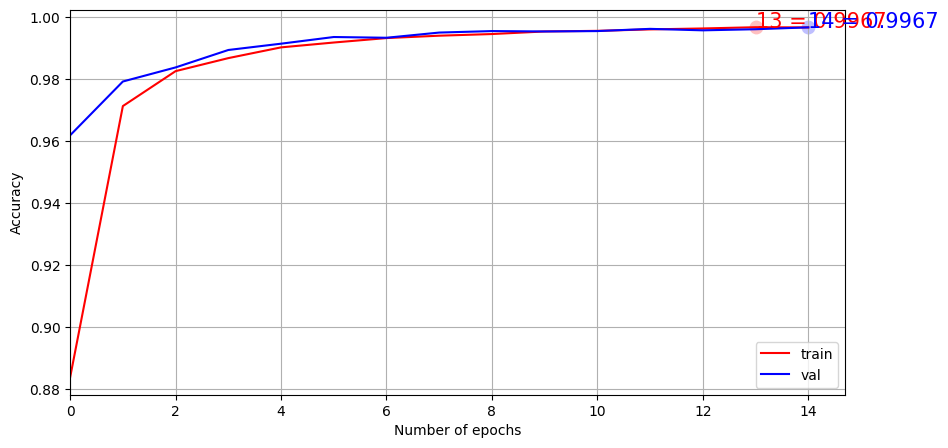

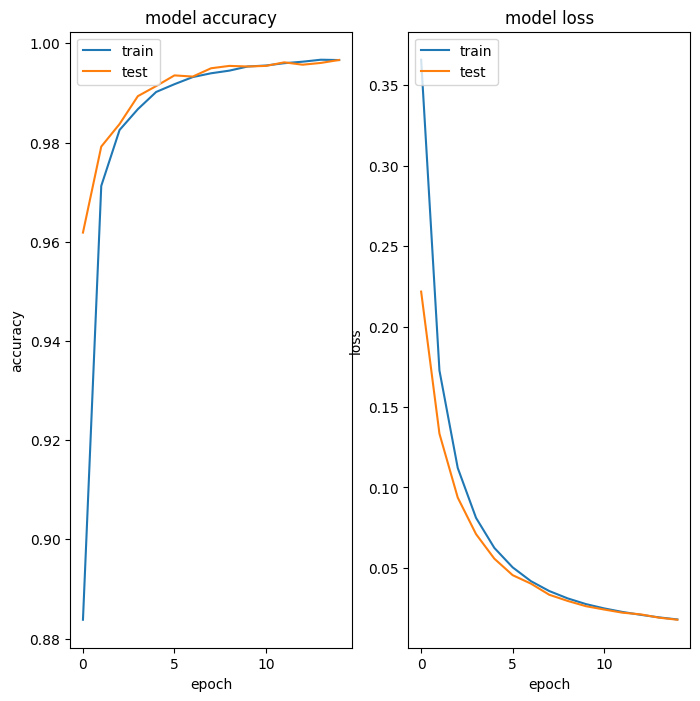

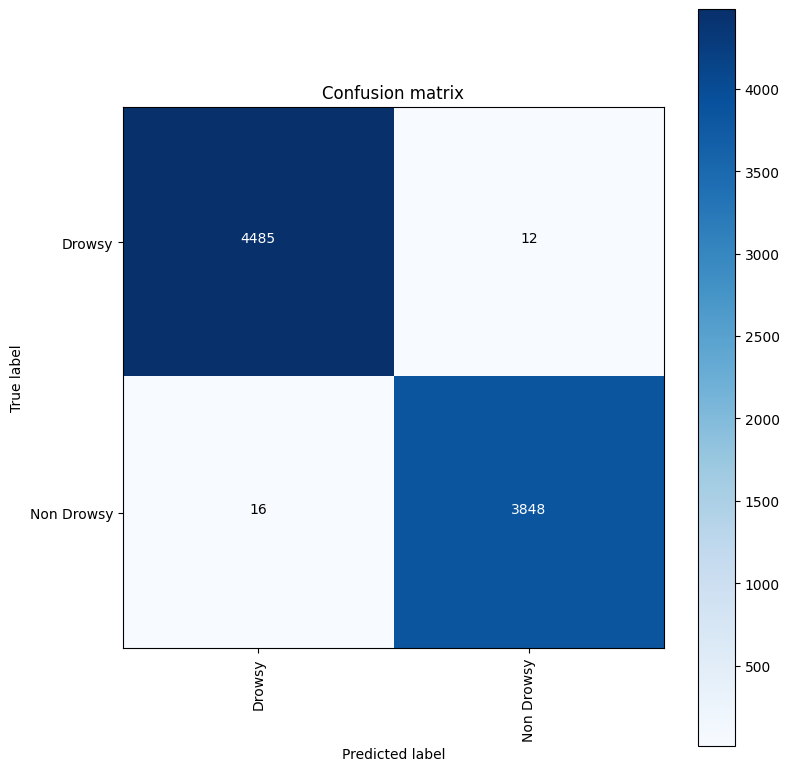

In [ ]:
pretrainedNetwork(X_train, y_trainHot, X_test, y_testHot,model_1,weight_path1,class_weights,2,15,optimizer1,map_characters)

In [ ]:
gc.collect()

17914